# Sprint 3: Phân loại trình độ văn bản tiếng Anh với Word2Vec, XGBoost và SHAP

Notebook này thực hiện một quy trình Machine Learning hoàn chỉnh:
1.  **Tải dữ liệu** đã được tiền xử lý từ Sprint trước.
2.  **Huấn luyện Word2Vec** để tạo ra các vector đặc trưng mới cho văn bản.
3.  **Huấn luyện và so sánh** nhiều mô hình phân loại (Logistic Regression, XGBoost, Random Forest) trên cả hai bộ đặc trưng (TF-IDF và Word2Vec).
4.  **Tinh chỉnh siêu tham số** cho mô hình tốt nhất bằng `GridSearchCV`.
5.  **Đánh giá cuối cùng** trên tập dữ liệu kiểm thử (test set).
6.  **Giải thích kết quả** của mô hình bằng thư viện `SHAP`.

## Cài đặt và Import các thư viện cần thiết

In [38]:
%pip install pandas numpy scipy gensim nltk scikit-learn xgboost shap matplotlib
# Dòng trên để cài đặt thư viện nếu cần. Bỏ comment và chạy nếu bạn chưa cài.

Note: you may need to restart the kernel to use updated packages.


In [39]:
import pandas as pd
import numpy as np
import pickle
import time
import joblib
import nltk

# Tiền xử lý & Vector hóa
from scipy.sparse import load_npz, vstack
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder

# Mô hình
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Đánh giá & Tinh chỉnh
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

# Giải thích mô hình
import shap

# Đảm bảo bạn đã tải NLTK tokenizer
# nltk.download('punkt', quiet=True)

## BƯỚC 1: TẢI DỮ LIỆU TỪ SPRINT 2

In [40]:
print("Đang tải dữ liệu đã xử lý từ /dataframes/...")

# Tải ma trận TF-IDF (vẫn cần để so sánh)
X_train_tfidf = load_npz('dataframes/X_train_tfidf.npz')
X_val_tfidf = load_npz('dataframes/X_val_tfidf.npz')
X_test_tfidf = load_npz('dataframes/X_test_tfidf.npz')

# Tải nhãn
y_train = pd.read_csv('dataframes/y_train.csv')['label']
y_val = pd.read_csv('dataframes/y_val.csv')['label']
y_test = pd.read_csv('dataframes/y_test.csv')['label']

# Tải văn bản thô (raw text) để huấn luyện Word2Vec
print("Đang tải văn bản thô (train_data.csv, val_data.csv, test_data.csv)...")
df_train = pd.read_csv('dataframes/train_data.csv')
df_val = pd.read_csv('dataframes/val_data.csv')
df_test = pd.read_csv('dataframes/test_data.csv')

# Lấy cột văn bản đã làm sạch và đảm bảo không có giá trị NaN
corpus_train = df_train['text'].dropna()
corpus_val = df_val['text'].dropna()
corpus_test = df_test['text'].dropna()

print("Tải dữ liệu hoàn tất.")

Đang tải dữ liệu đã xử lý từ /dataframes/...
Đang tải văn bản thô (train_data.csv, val_data.csv, test_data.csv)...
Tải dữ liệu hoàn tất.


### Mã hóa nhãn (Label Encoding)

In [41]:
print("Đang mã hóa nhãn (A1->0, A2->1...)...")
le = LabelEncoder()

# Fit trên y_train và transform
y_train_encoded = le.fit_transform(y_train)

# Chỉ transform y_val và y_test
y_val_encoded = le.transform(y_val)
y_test_encoded = le.transform(y_test)

# Lấy tên các nhãn gốc để dùng trong báo cáo
class_names = le.classes_
print(f"Đã mã hóa nhãn: {class_names} -> {le.transform(class_names)}")

Đang mã hóa nhãn (A1->0, A2->1...)...
Đã mã hóa nhãn: ['A1' 'A2' 'B1' 'B2'] -> [0 1 2 3]


## BƯỚC 2: HUẤN LUYỆN WORD2VEC & TẠO FEATURE TRUNG BÌNH

In [42]:
print("--- [Thử nghiệm 3] Đang tạo features bằng Word2Vec ---")

# 1. Chuẩn bị dữ liệu: Word2Vec cần đầu vào là một list các list token (câu).
print("Đang token hóa (phân tách từ) văn bản huấn luyện...")
tokenized_corpus = [word_tokenize(doc) for doc in corpus_train]

# 2. Huấn luyện mô hình Word2Vec
W2V_SIZE = 300
W2V_WINDOW = 5
W2V_MIN_COUNT = 5

print(f"Đang huấn luyện mô hình Word2Vec (size={W2V_SIZE})...")
w2v_model = Word2Vec(
    sentences=tokenized_corpus,
    vector_size=W2V_SIZE,
    window=W2V_WINDOW,
    min_count=W2V_MIN_COUNT,
    workers=4
)
print("Huấn luyện Word2Vec hoàn tất.")

# Lấy ra bộ từ vựng mà Word2Vec đã học
w2v_vocab = set(w2v_model.wv.index_to_key)
print(f"Kích thước từ vựng Word2Vec: {len(w2v_vocab)} từ")

--- [Thử nghiệm 3] Đang tạo features bằng Word2Vec ---
Đang token hóa (phân tách từ) văn bản huấn luyện...
Đang huấn luyện mô hình Word2Vec (size=300)...


Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


Huấn luyện Word2Vec hoàn tất.
Kích thước từ vựng Word2Vec: 59937 từ


### Tạo ma trận đặc trưng từ Word2Vec (Vector Averaging)

In [43]:
def get_document_vector(doc, model, num_features):
    """
    Tính vector trung bình cho một văn bản (doc).
    """
    tokens = word_tokenize(doc)
    
    # Lọc ra các từ có trong từ vựng của Word2Vec
    valid_tokens = [word for word in tokens if word in w2v_vocab]
    
    if not valid_tokens:
        # Nếu không có từ nào trong từ vựng, trả về vector 0
        return np.zeros(num_features)
    
    # Lấy vector cho từng từ và tính trung bình
    doc_vector = np.mean([model.wv[word] for word in valid_tokens], axis=0)
    return doc_vector

# Áp dụng hàm cho các tập Train, Val, Test
print("Đang tạo ma trận vector trung bình cho Train/Val/Test...")

X_train_w2v = np.array([get_document_vector(doc, w2v_model, W2V_SIZE) for doc in corpus_train])
X_val_w2v = np.array([get_document_vector(doc, w2v_model, W2V_SIZE) for doc in corpus_val])
X_test_w2v = np.array([get_document_vector(doc, w2v_model, W2V_SIZE) for doc in corpus_test])

print("Tạo ma trận Word2Vec hoàn tất.")
print(f"Kích thước X_train (TF-IDF): {X_train_tfidf.shape}")
print(f"Kích thước X_train (Word2Vec): {X_train_w2v.shape}")

Đang tạo ma trận vector trung bình cho Train/Val/Test...
Tạo ma trận Word2Vec hoàn tất.
Kích thước X_train (TF-IDF): (1261, 5000)
Kích thước X_train (Word2Vec): (1261, 300)


## BƯỚC 3: HUẤN LUYỆN LOGISTIC REGRESSION (VỚI WORD2VEC)

In [44]:
print("--- Đang huấn luyện Logistic Regression với Word2Vec (So sánh) ---")

model_lr_w2v = LogisticRegression(max_iter=1000, random_state=42)
model_lr_w2v.fit(X_train_w2v, y_train_encoded)

print("Đánh giá Logistic Regression (Word2Vec) trên tập Validation:")
y_pred_val_w2v = model_lr_w2v.predict(X_val_w2v)
print(classification_report(y_val_encoded, y_pred_val_w2v, target_names=class_names))

--- Đang huấn luyện Logistic Regression với Word2Vec (So sánh) ---
Đánh giá Logistic Regression (Word2Vec) trên tập Validation:
              precision    recall  f1-score   support

          A1       0.81      0.91      0.86       101
          A2       0.58      0.50      0.54        30
          B1       0.44      0.20      0.28        20
          B2       0.69      0.76      0.72        29

    accuracy                           0.74       180
   macro avg       0.63      0.59      0.60       180
weighted avg       0.71      0.74      0.72       180



## BƯỚC 4: HUẤN LUYỆN XGBOOST (VỚI WORD2VEC)

In [45]:
print("--- [Thử nghiệm 4] Đang huấn luyện XGBoost với Word2Vec ---")

model_xgb_w2v = XGBClassifier(
    random_state=42,
    n_estimators=200,      # Số lượng cây
    max_depth=5,           # Độ sâu tối đa của cây
    learning_rate=0.1,     # Tốc độ học
    objective='multi:softmax', # Cho bài toán đa lớp
    num_class=len(class_names), # Số lượng lớp
    n_jobs=-1              # Sử dụng tất cả các CPU
)

print("Đang huấn luyện XGBoost (Word2Vec)... (có thể mất vài phút)")
start_time = time.time()
model_xgb_w2v.fit(X_train_w2v, y_train_encoded)
end_time = time.time()
print(f"Huấn luyện hoàn tất sau {end_time - start_time:.2f} giây.")

print("\nĐánh giá XGBoost (Word2Vec) trên tập Validation:")
y_pred_val_xgb = model_xgb_w2v.predict(X_val_w2v)
print(classification_report(y_val_encoded, y_pred_val_xgb, target_names=class_names))

--- [Thử nghiệm 4] Đang huấn luyện XGBoost với Word2Vec ---
Đang huấn luyện XGBoost (Word2Vec)... (có thể mất vài phút)
Huấn luyện hoàn tất sau 7.36 giây.

Đánh giá XGBoost (Word2Vec) trên tập Validation:
              precision    recall  f1-score   support

          A1       0.85      0.92      0.88       101
          A2       0.62      0.50      0.56        30
          B1       0.47      0.40      0.43        20
          B2       0.69      0.69      0.69        29

    accuracy                           0.76       180
   macro avg       0.66      0.63      0.64       180
weighted avg       0.74      0.76      0.75       180



## BƯỚC 5: HUẤN LUYỆN XGBOOST (VỚI TF-IDF)

In [46]:
print("--- [Thử nghiệm 2] Đang huấn luyện XGBoost với TF-IDF ---")

model_xgb_tfidf = XGBClassifier(
    random_state=42,
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    objective='multi:softmax',
    num_class=len(class_names),
    n_jobs=-1
)

print("Đang huấn luyện XGBoost (TF-IDF)...")
start_time = time.time()
model_xgb_tfidf.fit(X_train_tfidf, y_train_encoded)
end_time = time.time()
print(f"Huấn luyện hoàn tất sau {end_time - start_time:.2f} giây.")

print("\nĐánh giá XGBoost (TF-IDF) trên tập Validation:")
y_pred_val_xgb_tfidf = model_xgb_tfidf.predict(X_val_tfidf)
print(classification_report(y_val_encoded, y_pred_val_xgb_tfidf, target_names=class_names))

--- [Thử nghiệm 2] Đang huấn luyện XGBoost với TF-IDF ---
Đang huấn luyện XGBoost (TF-IDF)...
Huấn luyện hoàn tất sau 36.86 giây.

Đánh giá XGBoost (TF-IDF) trên tập Validation:
              precision    recall  f1-score   support

          A1       0.90      0.97      0.93       101
          A2       0.74      0.57      0.64        30
          B1       0.44      0.40      0.42        20
          B2       0.70      0.72      0.71        29

    accuracy                           0.80       180
   macro avg       0.70      0.67      0.68       180
weighted avg       0.79      0.80      0.79       180



## BƯỚC 6: HUẤN LUYỆN RANDOM FOREST (VỚI WORD2VEC & TF-IDF)

In [47]:
print("--- [Thử nghiệm 5] Đang huấn luyện Random Forest với Word2Vec ---")
model_rf_w2v = RandomForestClassifier(
    n_estimators=200,  # Số lượng cây, tương tự XGBoost
    random_state=42,
    n_jobs=-1          # Sử dụng tất cả CPU
)

print("Đang huấn luyện Random Forest (Word2Vec)...")
start_time = time.time()
model_rf_w2v.fit(X_train_w2v, y_train_encoded)
end_time = time.time()
print(f"Huấn luyện hoàn tất sau {end_time - start_time:.2f} giây.")

print("\nĐánh giá Random Forest (Word2Vec) trên tập Validation:")
y_pred_val_rf_w2v = model_rf_w2v.predict(X_val_w2v)
print(classification_report(y_val_encoded, y_pred_val_rf_w2v, target_names=class_names))

--- [Thử nghiệm 5] Đang huấn luyện Random Forest với Word2Vec ---
Đang huấn luyện Random Forest (Word2Vec)...
Huấn luyện hoàn tất sau 0.44 giây.

Đánh giá Random Forest (Word2Vec) trên tập Validation:
              precision    recall  f1-score   support

          A1       0.78      0.92      0.85       101
          A2       0.58      0.37      0.45        30
          B1       0.46      0.30      0.36        20
          B2       0.66      0.66      0.66        29

    accuracy                           0.72       180
   macro avg       0.62      0.56      0.58       180
weighted avg       0.69      0.72      0.70       180



In [48]:
print("\n--- [Thử nghiệm 6] Đang huấn luyện Random Forest với TF-IDF ---")
model_rf_tfidf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)

print("Đang huấn luyện Random Forest (TF-IDF)...")
start_time = time.time()
model_rf_tfidf.fit(X_train_tfidf, y_train_encoded)
end_time = time.time()
print(f"Huấn luyện hoàn tất sau {end_time - start_time:.2f} giây.")

print("\nĐánh giá Random Forest (TF-IDF) trên tập Validation:")
y_pred_val_rf_tfidf = model_rf_tfidf.predict(X_val_tfidf)
print(classification_report(y_val_encoded, y_pred_val_rf_tfidf, target_names=class_names))


--- [Thử nghiệm 6] Đang huấn luyện Random Forest với TF-IDF ---
Đang huấn luyện Random Forest (TF-IDF)...
Huấn luyện hoàn tất sau 0.50 giây.

Đánh giá Random Forest (TF-IDF) trên tập Validation:
              precision    recall  f1-score   support

          A1       0.85      0.99      0.92       101
          A2       0.67      0.47      0.55        30
          B1       1.00      0.05      0.10        20
          B2       0.66      0.93      0.77        29

    accuracy                           0.79       180
   macro avg       0.79      0.61      0.58       180
weighted avg       0.81      0.79      0.74       180



## BƯỚC 7: TINH CHỈNH SIÊU THAM SỐ (HYPERPARAMETER TUNING)

Dựa trên các kết quả trên, mô hình `XGBoost + TF-IDF` cho kết quả tốt nhất. Chúng ta sẽ tinh chỉnh siêu tham số cho mô hình này.

**Lưu ý:** Quá trình này sẽ mất rất nhiều thời gian (có thể từ 10-30 phút hoặc hơn tùy vào cấu hình máy và `param_grid`).

#### 7.1. Gộp dữ liệu Train và Validation

In [49]:
# Gộp dữ liệu Train và Validation để GridSearchCV có thể tự thực hiện Cross-Validation trên toàn bộ dữ liệu.
print("Gộp dữ liệu Train và Validation để tinh chỉnh...")
X_train_val_tfidf = vstack([X_train_tfidf, X_val_tfidf])
y_train_val_encoded = np.concatenate([y_train_encoded, y_val_encoded])
print(f"Kích thước dữ liệu gộp: {X_train_val_tfidf.shape}")

Gộp dữ liệu Train và Validation để tinh chỉnh...
Kích thước dữ liệu gộp: (1441, 5000)


#### 7.2. Thiết lập GridSearchCV

In [50]:
# Định nghĩa lưới tham số (Param Grid) - các tham số bạn muốn thử.
param_grid = {
    'n_estimators': [200, 300],      # Số lượng cây
    'max_depth': [5, 7],             # Độ sâu tối đa
    'learning_rate': [0.1, 0.15],    # Tốc độ học
    'subsample': [0.8, 1.0]          # Tỷ lệ mẫu dùng cho mỗi cây
}

# Khởi tạo mô hình XGBoost Gốc để tinh chỉnh
base_xgb_model = XGBClassifier(
    objective='multi:softmax',
    num_class=len(class_names),
    random_state=42,
    n_jobs=-1
)

# Khởi tạo GridSearchCV
grid_search = GridSearchCV(
    estimator=base_xgb_model,
    param_grid=param_grid,
    cv=3, # 3-fold cross-validation
    scoring='accuracy',
    verbose=3, # In log chi tiết
    n_jobs=-1  # Sử dụng tất cả CPU
)

#### 7.3. Chạy Tinh chỉnh (Long-running task)

In [51]:
print("\nBắt đầu Grid Search... (Việc này sẽ mất RẤT LÂU)...")
start_time = time.time()
grid_search.fit(X_train_val_tfidf, y_train_val_encoded)
end_time = time.time()
print(f"\nGrid Search hoàn tất sau {end_time - start_time:.2f} giây.")


Bắt đầu Grid Search... (Việc này sẽ mất RẤT LÂU)...
Fitting 3 folds for each of 16 candidates, totalling 48 fits

Grid Search hoàn tất sau 891.71 giây.


#### 7.4. Xem kết quả và lấy ra mô hình tốt nhất

In [52]:
print("--- Kết quả Tinh chỉnh ---")
print(f"Accuracy tốt nhất tìm được (trên tập Val): {grid_search.best_score_ * 100:.2f}%")
print(f"Bộ tham số tốt nhất: {grid_search.best_params_}")

# Lấy ra mô hình TỐT NHẤT
best_tuned_model = grid_search.best_estimator_

# Lưu lại mô hình tốt nhất để sử dụng sau này
print("Lưu mô hình tốt nhất vào file 'best_tuned_model.pkl'...")
joblib.dump(best_tuned_model, 'best_tuned_model.pkl')
print("Lưu mô hình hoàn tất.")

--- Kết quả Tinh chỉnh ---
Accuracy tốt nhất tìm được (trên tập Val): 78.07%
Bộ tham số tốt nhất: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Lưu mô hình tốt nhất vào file 'best_tuned_model.pkl'...
Lưu mô hình hoàn tất.


## BƯỚC 8: ĐÁNH GIÁ CUỐI CÙNG TRÊN TẬP TEST

In [53]:
print("--- [Bước 8] Đánh giá Cuối cùng trên TẬP TEST ---")

# Dùng mô hình đã được tinh chỉnh để dự đoán trên tập Test
y_pred_test_final = best_tuned_model.predict(X_test_tfidf)

print("\nBáo cáo Phân loại CUỐI CÙNG của mô hình tốt nhất (trên tập Test):")
print(classification_report(y_test_encoded, y_pred_test_final, target_names=class_names))

--- [Bước 8] Đánh giá Cuối cùng trên TẬP TEST ---

Báo cáo Phân loại CUỐI CÙNG của mô hình tốt nhất (trên tập Test):
              precision    recall  f1-score   support

          A1       0.86      0.94      0.90       202
          A2       0.58      0.51      0.54        61
          B1       0.48      0.27      0.34        41
          B2       0.63      0.72      0.67        57

    accuracy                           0.76       361
   macro avg       0.64      0.61      0.62       361
weighted avg       0.74      0.76      0.74       361



## BƯỚC 9: GIẢI THÍCH MÔ HÌNH VỚI SHAP

Chúng ta sẽ sử dụng mô hình tốt nhất vừa tìm được (`best_tuned_model`) để xem tại sao nó lại đưa ra các dự đoán như vậy.

**Lưu ý:** `KernelExplainer` có thể chạy khá chậm.

#### 9.1. Tạo đối tượng Explainer

In [54]:
print("--- [Bước 9.1] Chuẩn bị cho SHAP ---")

# --- Đảm bảo các đối tượng cần thiết đã tồn tại trong bộ nhớ ---
# 1. Tải lại model
if 'best_tuned_model' not in locals():
    print("Đang tải lại 'best_tuned_model.pkl'...")
    best_tuned_model = joblib.load('best_tuned_model.pkl')

# 2. Tải lại dữ liệu TF-IDF (nếu chưa có)
if 'X_train_tfidf' not in locals():
    print("Đang tải lại dữ liệu TF-IDF...")
    X_train_tfidf = load_npz('dataframes/X_train_tfidf.npz')
    X_val_tfidf = load_npz('dataframes/X_val_tfidf.npz')
    X_test_tfidf = load_npz('dataframes/X_test_tfidf.npz')

# 3. Gộp Train + Val để làm nền (nếu chưa có)
if 'X_train_val_tfidf' not in locals():
    print("Đang gộp dữ liệu Train + Val...")
    X_train_val_tfidf = vstack([X_train_tfidf, X_val_tfidf])

# 4. Tải lại tên features (nếu chưa có)
if 'feature_names' not in locals():
    print("Đang tải lại 'tfidf_vectorizer.pkl'...")
    with open('dataframes/tfidf_vectorizer.pkl', 'rb') as f:
        tfidf_vectorizer = pickle.load(f)
    feature_names = tfidf_vectorizer.get_feature_names_out()

# 5. Khởi tạo Javascript của SHAP
shap.initjs()
print("Chuẩn bị SHAP hoàn tất.")

--- [Bước 9.1] Chuẩn bị cho SHAP ---
Đang tải lại 'tfidf_vectorizer.pkl'...


Chuẩn bị SHAP hoàn tất.


#### 9.2. Tính toán giá trị SHAP (Long-running task)

In [55]:
print("--- [Bước 9.2] Tạo SHAP Explainer ---")

# GIẢI PHÁP: Dùng `shap.sample` để lấy 100 mẫu nền (thay vì toàn bộ 1441 dòng)
# và chuyển 100 mẫu này sang dạng .toarray() (dense).
print("Lấy 100 mẫu nền (background sample)...")
background_sample = shap.sample(X_train_val_tfidf, 100).toarray()

# Khởi tạo TreeExplainer với `feature_perturbation="interventional"`
# để tương thích tốt nhất với mô hình và dữ liệu.
print("Đang tạo SHAP TreeExplainer...")
explainer = shap.TreeExplainer(
    best_tuned_model, 
    background_sample, 
    feature_perturbation="interventional"
)
print("Tạo TreeExplainer hoàn tất.")

--- [Bước 9.2] Tạo SHAP Explainer ---
Lấy 100 mẫu nền (background sample)...
Đang tạo SHAP TreeExplainer...
Tạo TreeExplainer hoàn tất.


### Vẽ biểu đồ SHAP

SHAP cung cấp nhiều loại biểu đồ để trực quan hóa. Dưới đây là hai loại phổ biến nhất:
- **Force Plot**: Cho thấy các đặc trưng (từ) nào đã "đẩy" dự đoán về phía một lớp cụ thể cho một mẫu duy nhất.
- **Summary Plot**: Tổng hợp tác động của các đặc trưng trên nhiều mẫu.

In [56]:
# Lấy lại vectorizer để xem tên features
with open('dataframes/tfidf_vectorizer.pkl', 'rb') as f:
    tfidf_vectorizer = pickle.load(f)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Khởi tạo JS của SHAP để hiển thị biểu đồ tương tác
shap.initjs()

#### 9.3: Force Plot (Giải thích từng dự đoán)


In [60]:
print("--- [Bước 9.3] Chuẩn bị dữ liệu và Tính toán SHAP Values ---")

# --- 1. Tải các dữ liệu cần thiết từ tập Test ---
# (Chúng ta cần y_test để so sánh và df_test để xem văn bản gốc)
print("Đang tải dữ liệu test (văn bản và nhãn)...")
df_test = pd.read_csv('dataframes/test_data.csv')
y_test = pd.read_csv('dataframes/y_test.csv')['label']
y_test_encoded = le.transform(y_test) # Dùng 'le' từ Bước 1

# --- 2. Lấy 50 mẫu đầu tiên từ tập Test để giải thích ---
SAMPLES_TO_EXPLAIN = 50

print(f"Lấy {SAMPLES_TO_EXPLAIN} mẫu đầu tiên từ tập test...")
samples_to_explain_sparse = X_test_tfidf[0:SAMPLES_TO_EXPLAIN]
samples_to_explain_dense = samples_to_explain_sparse.toarray() # Chuyển sang dense

# Lấy văn bản, nhãn, và dự đoán tương ứng
test_texts_sample = df_test['text'].iloc[0:SAMPLES_TO_EXPLAIN].values
y_test_sample = y_test_encoded[0:SAMPLES_TO_EXPLAIN]
y_pred_sample = best_tuned_model.predict(samples_to_explain_sparse) # Lấy dự đoán

# --- 3. Tính toán SHAP ---
print(f"Đang tính toán giá trị SHAP cho {SAMPLES_TO_EXPLAIN} mẫu...")
# (explainer đã được tạo ở Cell 9.2)
shap_explanation = explainer(samples_to_explain_dense)
print("Tính toán SHAP hoàn tất.")

--- [Bước 9.3] Chuẩn bị dữ liệu và Tính toán SHAP Values ---
Đang tải dữ liệu test (văn bản và nhãn)...
Lấy 50 mẫu đầu tiên từ tập test...
Đang tính toán giá trị SHAP cho 50 mẫu...
Tính toán SHAP hoàn tất.


#### 9.4: Summary Plot (Tổng hợp các đặc trưng quan trọng)


--- [Bước 9.4] Phân tích Tổng quan (Bar Plot) ---
Biểu đồ này cho thấy 10 từ có ảnh hưởng trung bình lớn nhất cho MỖI LỚP.


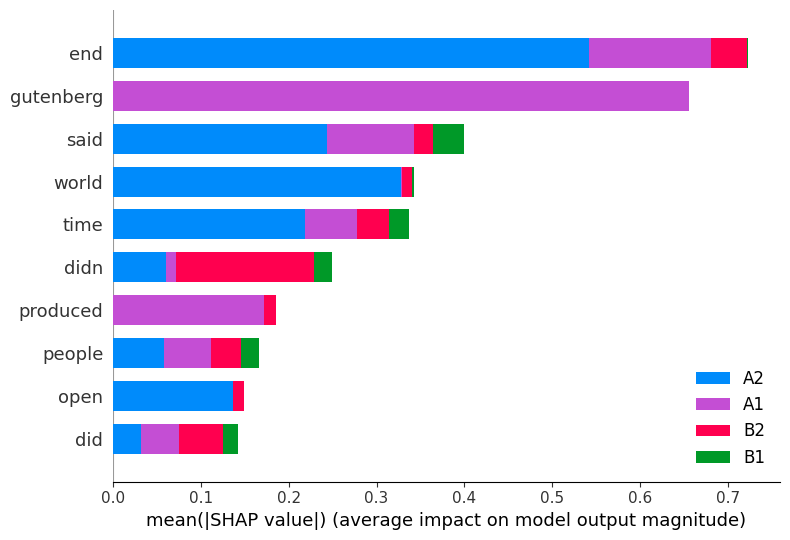

In [61]:
print("--- [Bước 9.4] Phân tích Tổng quan (Bar Plot) ---")
print("Biểu đồ này cho thấy 10 từ có ảnh hưởng trung bình lớn nhất cho MỖI LỚP.")

shap.summary_plot(
    shap_explanation.values,
    samples_to_explain_dense,
    feature_names=feature_names,
    class_names=class_names,
    plot_type="bar",
    max_display=10 # Chỉ hiển thị 10 từ hàng đầu
)

### 9.5: Phân tích Chuyên sâu (Beeswarm Plot - Lớp B1)

--- [Bước 9.5] Phân tích Chuyên sâu: Lớp B1 (index 2) ---
Đang vẽ Beeswarm Plot cho lớp 'B1'


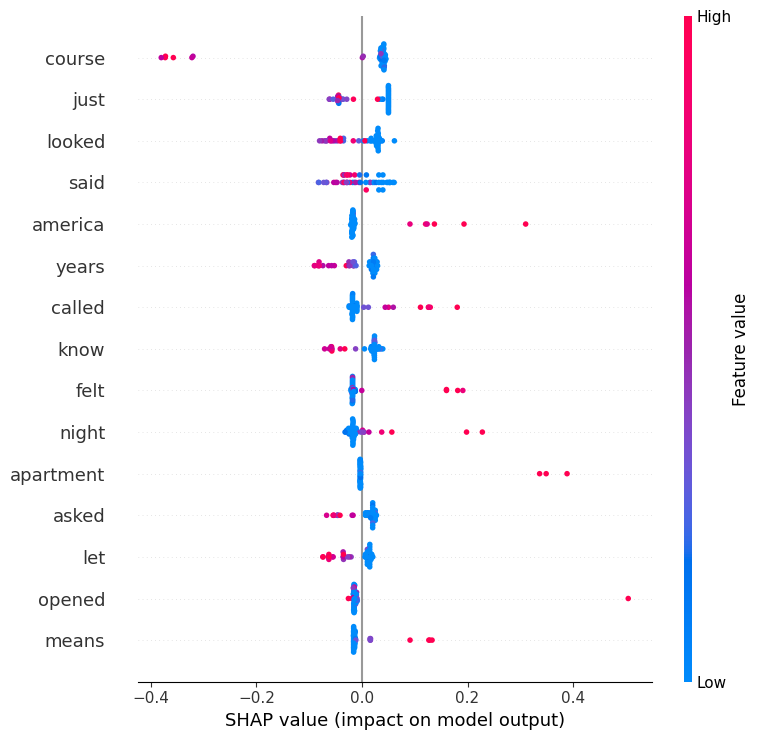

In [62]:
print("--- [Bước 9.5] Phân tích Chuyên sâu: Lớp B1 (index 2) ---")

class_index = 2 # 0: A1, 1: A2, 2: B1, 3: B2
print(f"Đang vẽ Beeswarm Plot cho lớp '{class_names[class_index]}'")

# Giải thích:
# - Mỗi điểm là một từ trong một câu.
# - Trục X là "SHAP value" (tác động lên dự đoán).
#   - X > 0: Từ này "ĐẨY" dự đoán về phía B1.
#   - X < 0: Từ này "KÉO" dự đoán ra xa B1 (về phía A1, A2, B2).
# - Màu sắc:
#   - Màu Đỏ: Giá trị TF-IDF cao (từ này quan trọng/xuất hiện nhiều).
#   - Màu Xanh: Giá trị TF-IDF thấp (từ này ít quan trọng/xuất hiện ít).

shap.summary_plot(
    shap_explanation.values[:, :, class_index], 
    samples_to_explain_dense, 
    feature_names=feature_names,
    max_display=15 # 15 từ quan trọng nhất
)

### Case Study 1 - Tại sao mô hình dự đoán SAI (False Negative)


--- Case Study 1: Mẫu B1 bị dự đoán SAI (False Negative) ---
Đang phân tích mẫu index 14 (trong 50 mẫu)...
Văn bản gốc: ...  the holiday has a special meaning to most americans today it is an official government holiday celebrated on december most americans get both christmas day and christmas eve off from their jobs so th ...
Dự đoán là: B2
Thực tế là: B1

Lý do dự đoán SAI (phân tích lớp B2):


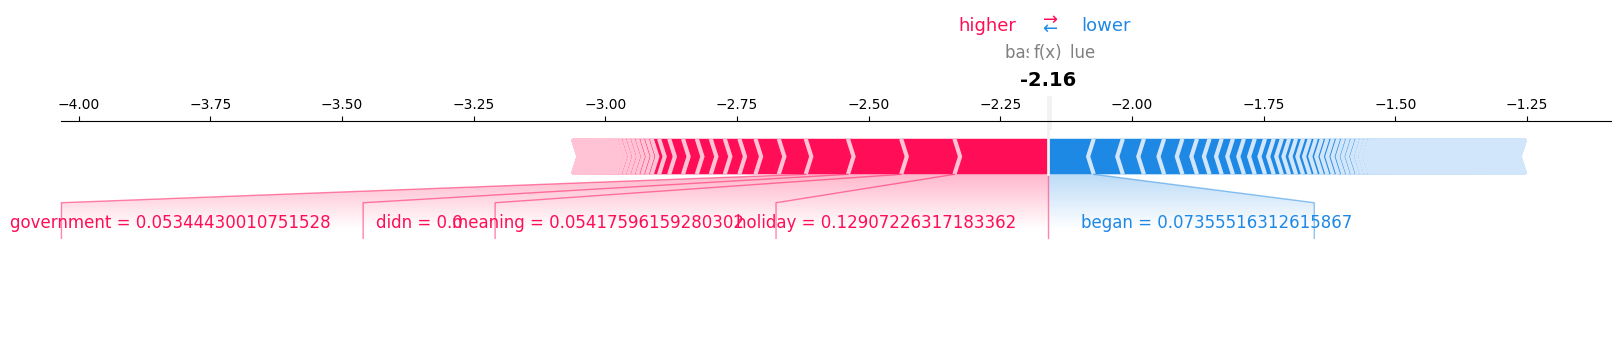

In [66]:
print("--- Case Study 1: Mẫu B1 bị dự đoán SAI (False Negative) ---")

# Tìm một mẫu là B1 (2) nhưng bị dự đoán là lớp khác
actual_b1 = (y_test_sample == 2)
predicted_not_b1 = (y_pred_sample != 2)
misclassified_indices = np.where(actual_b1 & predicted_not_b1)[0]

if len(misclassified_indices) > 0:
    idx = misclassified_indices[0] # Lấy mẫu bị sai đầu tiên
    wrong_class_index = y_pred_sample[idx]

    print(f"Đang phân tích mẫu index {idx} (trong {SAMPLES_TO_EXPLAIN} mẫu)...")
    print(f"Văn bản gốc: ... {test_texts_sample[idx][50:250]} ...") # In một đoạn
    print(f"Dự đoán là: {class_names[wrong_class_index]}")
    print(f"Thực tế là: {class_names[y_test_sample[idx]]}")

    print(f"\nLý do dự đoán SAI (phân tích lớp {class_names[wrong_class_index]}):")
    # Giải thích tại sao mô hình lại CHỌN lớp sai
    shap.force_plot(
        shap_explanation.base_values[idx, wrong_class_index],
        shap_explanation.values[idx, :, wrong_class_index],
        samples_to_explain_dense[idx],
        feature_names=feature_names,
        matplotlib=True
    )
else:
    print(f"Tuyệt vời! Không tìm thấy mẫu B1 nào bị dự đoán sai trong {SAMPLES_TO_EXPLAIN} mẫu đầu tiên.")

### Case Study 2 - Tại sao mô hình dự đoán ĐÚNG (True Positive)

--- Case Study 2: Mẫu B1 được dự đoán ĐÚNG (True Positive) ---
Đang phân tích mẫu index 34 (trong 50 mẫu)...
Văn bản gốc: ...  party to enjoy clever or catty comments about the super bowl twitter was ablaze sunday evening with running commentary about every conceivable aspect of super bowl xlvi from patriotstight end rob gro ...
Dự đoán là: B1
Thực tế là: B1

Lý do dự đoán ĐÚNG (phân tích lớp B1):


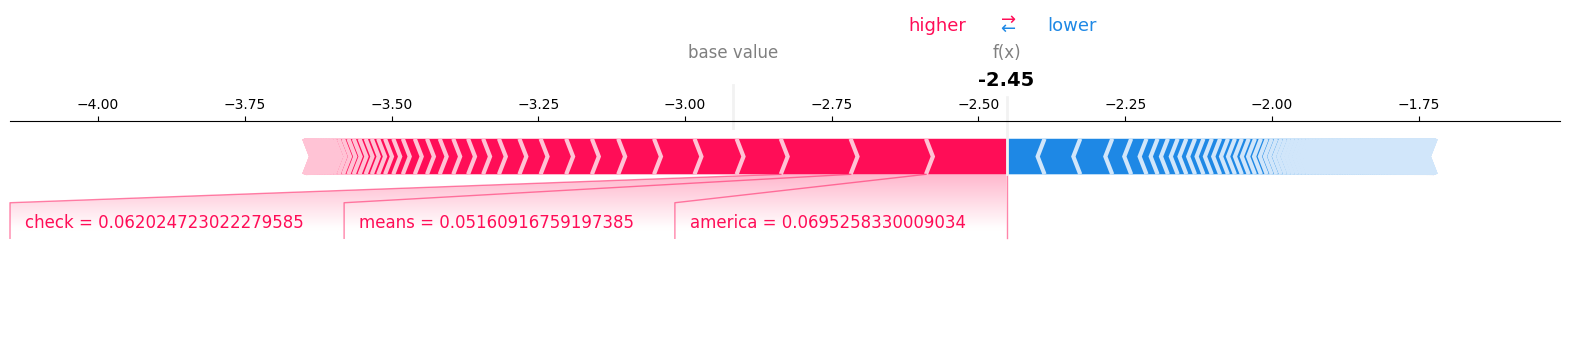

In [65]:
print("--- Case Study 2: Mẫu B1 được dự đoán ĐÚNG (True Positive) ---")

# Tìm một mẫu là B1 (2) và cũng được dự đoán là B1 (2)
actual_b1 = (y_test_sample == 2)
predicted_b1 = (y_pred_sample == 2)
correct_indices = np.where(actual_b1 & predicted_b1)[0]

if len(correct_indices) > 0:
    idx = correct_indices[0] # Lấy mẫu đúng đầu tiên
    class_index = 2

    print(f"Đang phân tích mẫu index {idx} (trong {SAMPLES_TO_EXPLAIN} mẫu)...")
    print(f"Văn bản gốc: ... {test_texts_sample[idx][50:250]} ...") # In một đoạn
    print(f"Dự đoán là: {class_names[y_pred_sample[idx]]}")
    print(f"Thực tế là: {class_names[y_test_sample[idx]]}")

    print(f"\nLý do dự đoán ĐÚNG (phân tích lớp {class_names[class_index]}):")
    # Giải thích tại sao mô hình CHỌN lớp B1
    shap.force_plot(
        shap_explanation.base_values[idx, class_index],
        shap_explanation.values[idx, :, class_index],
        samples_to_explain_dense[idx],
        feature_names=feature_names,
        matplotlib=True
    )
else:
    print(f"Không tìm thấy mẫu B1 nào được dự đoán đúng trong {SAMPLES_TO_EXPLAIN} mẫu đầu tiên.")